In [2]:
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import pickle
import lz4.frame
from wremnants import plot_tools, theory_corrections,theory_tools
from wremnants import boostHistHelpers as hh, histselections as sel
from scipy import special
import uproot

Welcome to JupyROOT 6.27/01


In [2]:
%load_ext autoreload
%autoreload 2

In [39]:
with lz4.frame.open("/home/k/kelong/work/WRemnants/w_z_gen_dists.pkl.lz4") as minnlof:
    minnlo = pickle.load(minnlof)

In [40]:
with lz4.frame.open("/home/k/kelong/work/WRemnants/w_z_gen_dists_genPartLowPrec.pkl.lz4") as minnlof_lowprec:
    minnlo_lowprec = pickle.load(minnlof_lowprec)

In [4]:
minnlo["ZmumuPostVFP"]["dataset"]["xsec"]

2001.9

In [41]:
minnlohZ = minnlo["ZmumuPostVFP"]["output"]["nominal_gen"]*minnlo["ZmumuPostVFP"]["dataset"]["xsec"]/minnlo["ZmumuPostVFP"]["weight_sum"]
minnlohW = (minnlo["WplusmunuPostVFP"]["output"]["nominal_gen"]*minnlo["WplusmunuPostVFP"]["dataset"]["xsec"]+minnlo["WminusmunuPostVFP"]["output"]["nominal_gen"])*minnlo["WminusmunuPostVFP"]["dataset"]["xsec"]/(minnlo["WplusmunuPostVFP"]["weight_sum"]+minnlo["WminusmunuPostVFP"]["weight_sum"])


In [42]:
minnlohZ_lowPrec = minnlo_lowprec["ZmumuPostVFP"]["output"]["nominal_gen"]*minnlo_lowprec["ZmumuPostVFP"]["dataset"]["xsec"]/minnlo_lowprec["ZmumuPostVFP"]["weight_sum"]



In [43]:
scetlibhZ_tot = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Z/inclusive_Z.npz", charge=0)
scetlibhZ_A4 = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/inclusive_Z_pT_A4.npz", nonsing=None, flip_y_sign=True, charge=0)
scetlibhZ_nons = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Z/inclusive_Z_nons.npz", nonsing=None, charge=0)

In [90]:
scetlibhZ_tot.shape

(1, 10, 40, 1, 1)

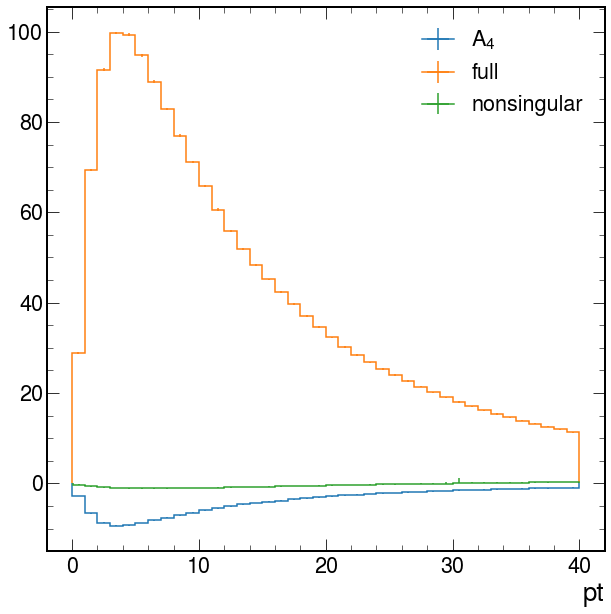

In [44]:
scetlibhZ_A4.project("pt").plot(label="A$_{4}$")
scetlibhZ_tot.project("pt").plot(label="full")
scetlibhZ_nons.project("pt").plot(label="nonsingular")
plt.legend()

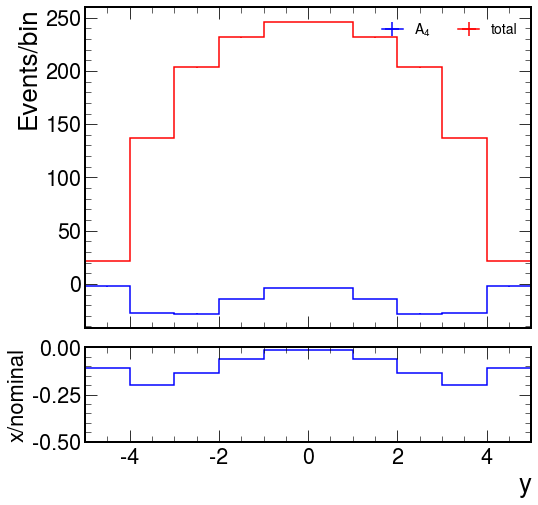

In [9]:
fig = plot_tools.makePlotWithRatioToRef([scetlibhZ_tot.project("y"), scetlibhZ_A4.project("y")], xlim=[-5, 5],colors=["red", "blue",], labels=["total", "A$_{4}$"], rrange=[-0.5, 0], binwnorm=1.)

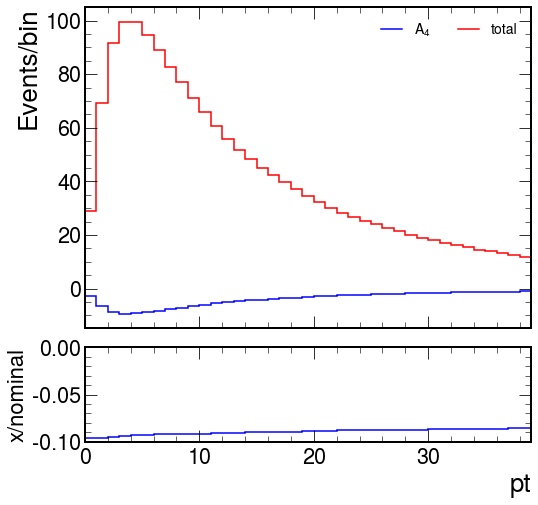

In [52]:
fig = plot_tools.makePlotWithRatioToRef([scetlibhZ_tot.project("pt"), scetlibhZ_A4.project("pt")],colors=["red", "blue",], labels=["total", "A$_{4}$"], rrange=[-0.1, 0], binwnorm=1.)

In [53]:
scetlibh = hh.makeAbsHist(scetlibhZ_tot, "y")

In [54]:
matrixRadish = theory_corrections.read_matrixRadish_hist("/home/k/kelong/MATRIX+RadISH/RadISH_observable_binning2__NNLO+N3LL.dat")

In [56]:
dyturbo = theory_corrections.read_dyturbo_hist(["z-cms-wmass-n3lonnll_bornres.txt", "z-cms-wmass-n3lonnll_ctres_2.txt", "z-cms-wmass-n3lonnll_vj_2.txt"], "/home/k/kelong/work/Generators/DYTurboResults/", )

In [57]:
s = hist.tag.Slicer()
minnlo_rebin, matrix_rad_rebin, dyturbo_rebin, scetlib_rebin = hh.rebinHistsToCommon([minnlohZ[{"massVgen": s[0:minnlohZ.axes["massVgen"].size:hist.sum]}].project("ptVgen"), matrixRadish, dyturbo, scetlibh.project('pt')], 0, True)


/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


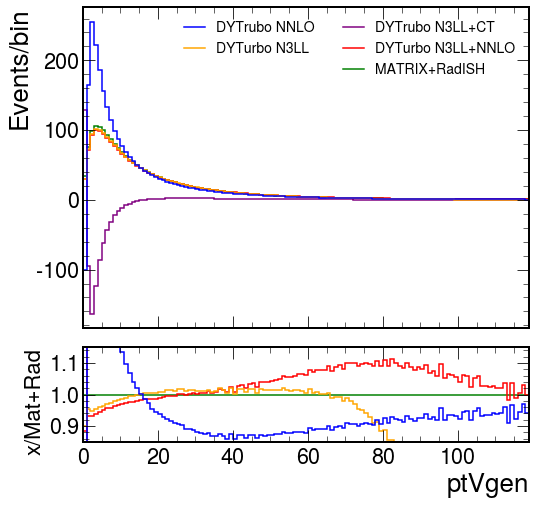

In [58]:
dyturbo_all = theory_corrections.read_dyturbo_hist(["z-cms-wmass-n3lonnll_bornres.txt", "z-cms-wmass-n3lonnll_ctres_2.txt", "z-cms-wmass-n3lonnll_vj_2.txt"], "/home/k/kelong/work/Generators/DYTurboResults/")
dyturbo_resum = theory_corrections.read_dyturbo_hist(["z-cms-wmass-n3lonnll_bornres.txt", "z-cms-wmass-n3lonnll_ctres_2.txt",], "/home/k/kelong/work/Generators/DYTurboResults/")
dyturbo_resumOnly = theory_corrections.read_dyturbo_hist(["z-cms-wmass-n3lonnll_bornres.txt",], "/home/k/kelong/work/Generators/DYTurboResults/")
dyturbo_fo = theory_corrections.read_dyturbo_hist(["z-cms-wmass-n3lonnll_vj_2.txt"], "/home/k/kelong/work/Generators/DYTurboResults/")


fig = plot_tools.makePlotWithRatioToRef([matrix_rad_rebin, dyturbo_all, dyturbo_resum, dyturbo_resumOnly, dyturbo_fo, ],colors=["green", "red", "purple", "orange", "blue",], labels=["MATRIX+RadISH", "DYTurbo N3LL+NNLO", "DYTrubo N3LL+CT", "DYTurbo N3LL", "DYTrubo NNLO", ], rrange=[0.85, 1.15], binwnorm=1., rlabel="x/Mat+Rad")

/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


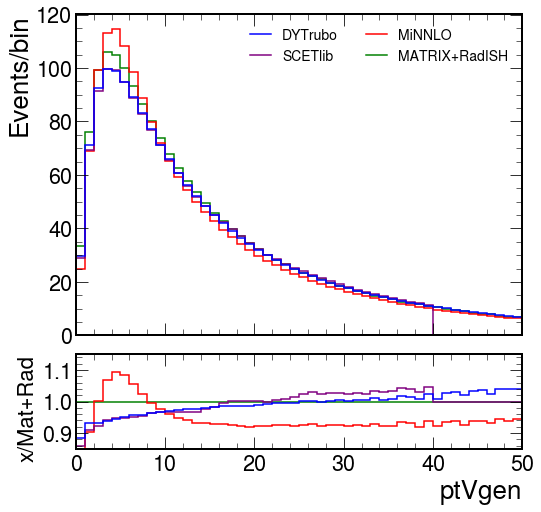

In [59]:
fig = plot_tools.makePlotWithRatioToRef([matrix_rad_rebin, minnlo_rebin, scetlib_rebin, dyturbo_rebin],colors=["green", "red", "purple", "blue", ], labels=["MATRIX+RadISH", "MiNNLO", "SCETlib", "DYTrubo", ], rrange=[0.85, 1.15], xlim=[0, 50], binwnorm=1., rlabel="x/Mat+Rad")

/opt/venv/lib/python3.10/site-packages/mplhep/error_estimation.py:48: RuntimeWarning: divide by zero encountered in true_divide
  counts = sumw / scale


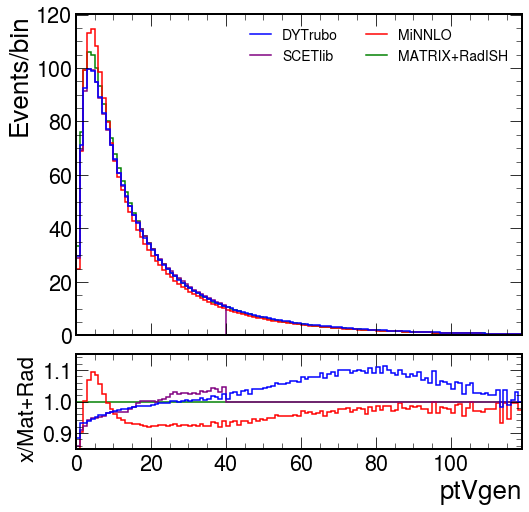

In [60]:
fig = plot_tools.makePlotWithRatioToRef([matrix_rad_rebin, minnlo_rebin, scetlib_rebin, dyturbo],colors=["green", "red", "purple", "blue", ], labels=["MATRIX+RadISH", "MiNNLO", "SCETlib", "DYTrubo", ], rrange=[0.85, 1.15], binwnorm=1., rlabel="x/Mat+Rad")

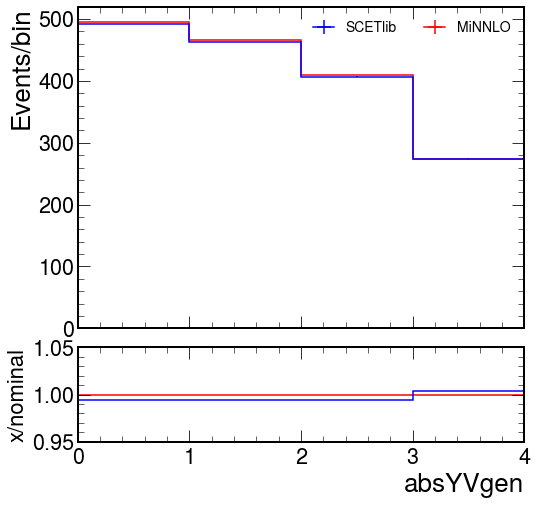

In [44]:
fig = plot_tools.makePlotWithRatioToRef([minnlo_rebin.project("absYVgen"), scetlibh.project("absy")],colors=["red", "blue",], labels=["MiNNLO", "SCETlib"], rrange=[0.95, 1.05], binwnorm=1.)


In [ ]:
x = corr[20.j:40.j].axes["ptVgen"].centers
params = np.polyfit(y=corr[20.j:40.j].values(), x=x, deg = 2)
poly = np.poly1d(params)
xeval = corr[30.j:40.j].axes["ptVgen"].centers

In [ ]:
corr_orig = corr.copy()
corr[30:40] = np.stack((poly(xeval), corr[30.j:40.j].variances()), axis=-1)

In [ ]:
minnloScetlib = hh.multiplyHists(minnlocorr, corrW)
minnloScetlib.plot()
matrixRadish.plot()

In [62]:
scetlibh_tot = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm.npz")
scetlibh_A4 = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_A4.npz", flip_y_sign=True)
scetlibh_tot_s = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm.npz", nonsing="")
scetlibh_tot.shape

(1, 40, 40, 1)

In [63]:
scetlib_A4_coeff = hh.divideHists(scetlibh_A4, scetlibh_tot, cutoff=0.0001)
scetlib_A4_coeff_pt = hh.divideHists(scetlibh_A4.project("pt"), scetlibh_tot.project("pt"), cutoff=0.0001)
scetlib_A4_coeff_y = hh.divideHists(scetlibh_A4.project("y"), scetlibh_tot.project("y"), cutoff=0.0001)

In [362]:
#scetlibW_y_tot = scetlib_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo.npz", add_nonsing=True)
#scetlibW_y_A4 = scetlib_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_y_binMinnlo_A4.npz", add_nonsing=True, flip_y_sign=True)

In [64]:
scetlibW_A4 = hh.makeAbsHist(scetlibh_A4, "y")
scetlibW_tot = hh.makeAbsHist(scetlibh_tot, "y")

In [65]:
scetlib_absy_A4_coeff = hh.divideHists(scetlibW_A4.project("absy"), scetlibW_tot.project("absy"))

Text(0.5, 1.0, 'SCETlib structure functions')

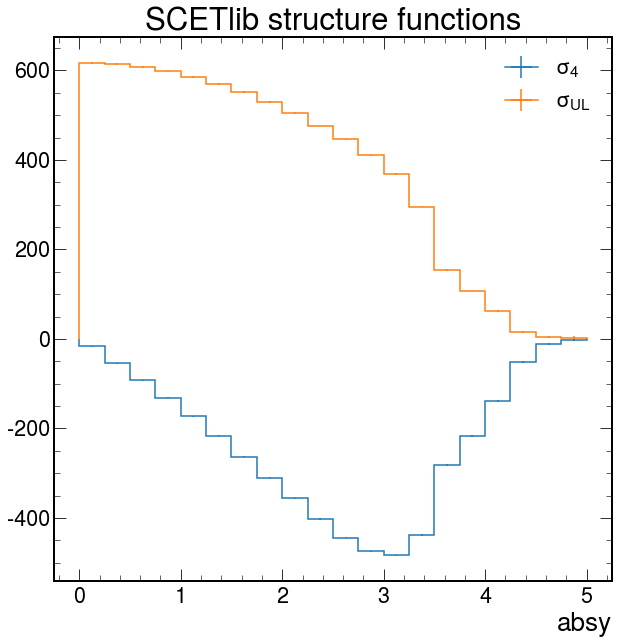

In [66]:
scetlibW_A4.project("absy").plot(label="$\sigma_{4}$")
scetlibW_tot.project("absy").plot(label="$\sigma_{UL}$")
plt.legend()
plt.title("SCETlib structure functions")

In [67]:
minnloZhel = minnlo["ZmumuPostVFP"]["output"]["helicity_moments_scale"]*minnlo["ZmumuPostVFP"]["dataset"]["xsec"]/minnlo["ZmumuPostVFP"]["weight_sum"]
minnloWmhel = minnlo["WminusmunuPostVFP"]["output"]["helicity_moments_scale"]*minnlo["WminusmunuPostVFP"]["dataset"]["xsec"]/minnlo["WminusmunuPostVFP"]["weight_sum"]
minnloWm = minnlo["WminusmunuPostVFP"]["output"]["nominal_gen"]*minnlo["WminusmunuPostVFP"]["dataset"]["xsec"]/minnlo["WminusmunuPostVFP"]["weight_sum"]

minnloWhel_cen = minnloWmhel[{"muRfact" : 1.j, "muFfact" : 1.j}]

In [108]:
minnloWhel_cen[{"helicity" : -1.j}].sum()

WeightedSum(value=8641.12, variance=0.47286)

In [76]:
minnlohW[{"chargeVgen" : -1.j}].sum(flow=True)

WeightedSum(value=3719.95, variance=0.0869161)

In [101]:
minnlo["WminusmunuPostVFP"]["dataset"]["xsec"]

8703.87

In [99]:
minnloWmhel[{"helicity" : -1.j}].sum(flow=True)

WeightedSum(value=78074.3, variance=6.1859)

In [68]:
hists = hh.rebinHistsToCommon([minnloWmhel[{"muRfact" : 1.j, "muFfact" : 1.j}], scetlibW_A4, scetlibW_tot], 2, False)
minnlohel_rebin, scetlibW_A4_rebin, scetlibW_tot_rebin = hh.rebinHistsToCommon(hists, 1, False)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f3273a638e0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

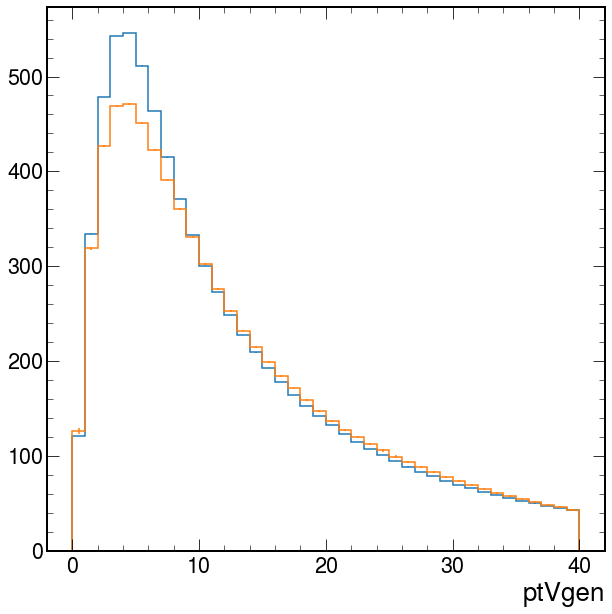

In [69]:
minnlohel_rebin[{"helicity" : -1.j}].project("ptVgen").plot()
scetlibW_tot_rebin.project("pt").plot()

In [111]:
minnlohel_scaled = theory_tools.scale_angular_moments(minnlohel_rebin)

In [112]:
print(minnlohel_rebin[{"helicity" : 4.j}].sum())
print(minnlohel_scaled[{"helicity" : -1.j}].sum())
print(scetlibW_tot_rebin.sum())

WeightedSum(value=-1177.93, variance=0.172322)
WeightedSum(value=7753.8, variance=0.439157)
WeightedSum(value=7518.07, variance=54.1536)


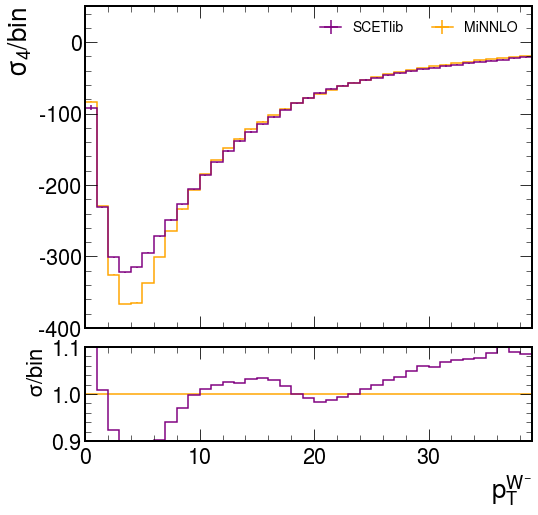

In [144]:
hists_to_plot = [minnlohel_scaled[{"helicity" : 4.j}].project("ptVgen"), scetlibW_A4_rebin.project("pt")]
fig = plot_tools.makePlotWithRatioToRef(hists_to_plot, colors=["orange", "purple",], ylim=[-400, 50], ylabel="$\sigma_{4}$/bin", xlabel=r"p$_{\mathrm{T}}^{\mathrm{W}^{-}}$", labels=["MiNNLO", "SCETlib"], rlabel="$\sigma$/bin", rrange=[0.9, 1.1], binwnorm=1.)


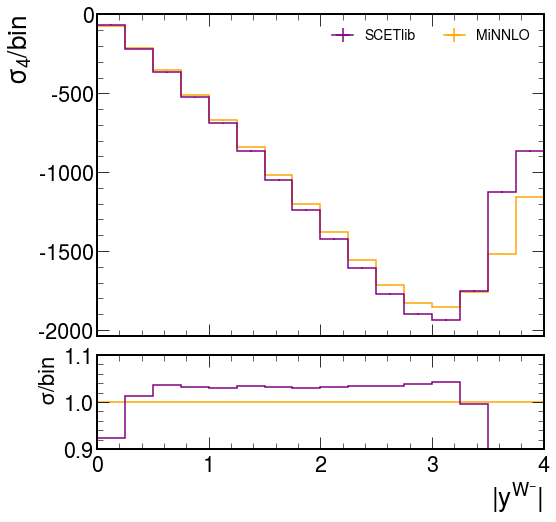

In [154]:
hists_to_plot = [minnlohel_scaled[{"helicity" : 4.j}].project("absYVgen"), scetlibW_A4_rebin.project("absy")]
fig = plot_tools.makePlotWithRatioToRef(hists_to_plot, colors=["orange", "purple",], ylabel="$\sigma_{4}$/bin", xlabel=r"$|\mathrm{y}^{\mathrm{W}^{-}}|$", labels=["MiNNLO", "SCETlib"], rlabel="$\sigma$/bin", rrange=[0.9, 1.1], binwnorm=1.)


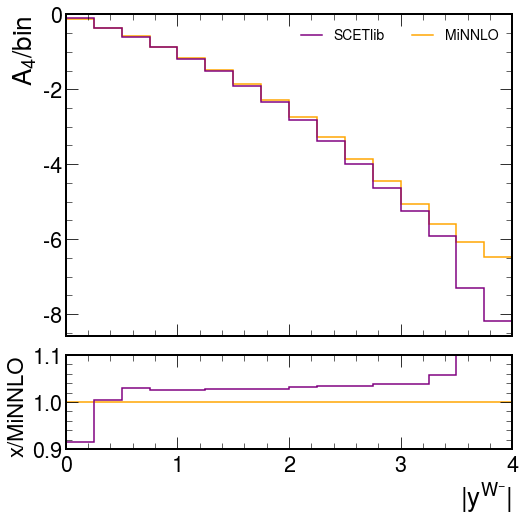

In [127]:
minnlo_coeffs = theory_tools.moments_to_angular_coeffs(minnlohel_rebin.project("absYVgen", "helicity"))
scetlib_A4_coeff = hh.divideHists(scetlibW_A4_rebin.project("absy"), scetlibW_tot_rebin.project("absy"))
coeff_hists_to_plot = [minnlo_coeffs[{"helicity" : 4.j}].project("absYVgen"), scetlib_A4_coeff.project("absy")]
fig = plot_tools.makePlotWithRatioToRef(coeff_hists_to_plot, colors=["orange", "purple",], rlabel="x/MiNNLO", ylabel="A$_{4}$/bin", xlabel=r"$|\mathrm{y}^{\mathrm{W}^{-}}|$", labels=["MiNNLO", "SCETlib"], rrange=[0.9, 1.1], binwnorm=1.)

In [136]:
scetlibZ_A4 = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Z/inclusive_Z_pT_A4.npz", nonsing="", flip_y_sign=True)
scetlibZ_tot = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Z/inclusive_Z_pT.npz")
scetlibZ_A4 = hh.makeAbsHist(scetlibZ_A4, "y")
scetlibZ_tot = hh.makeAbsHist(scetlibZ_tot, "y")

ValueError: axes not mergable

In [134]:
scetlibZ_tot.shape

(1, 5, 40, 1)

In [70]:
minnlohelZ = minnlo["ZmumuPostVFP"]["output"]["helicity_moments_scale"][{"muRfact" : 1.j, "muFfact" : 1.j}]*minnlo["ZmumuPostVFP"]["dataset"]["xsec"]/minnlo["ZmumuPostVFP"]["weight_sum"]

In [71]:
minnlohelZ_lowprec = minnlo_lowprec["ZmumuPostVFP"]["output"]["helicity_moments_scale"][{"muRfact" : 1.j, "muFfact" : 1.j}]*minnlo_lowprec["ZmumuPostVFP"]["dataset"]["xsec"]/minnlo_lowprec["ZmumuPostVFP"]["weight_sum"]

In [47]:
ha0 = sel.unrolledHist(minnlohelZ_coeffs[{"helicity" : 0.j}], ("ptVgen", "absYVgen"))
ha4 = sel.unrolledHist(minnlohelZ_coeffs[{"helicity" : 4.j}], ("absYVgen", "ptVgen", ))

(-1.0, 1.0)

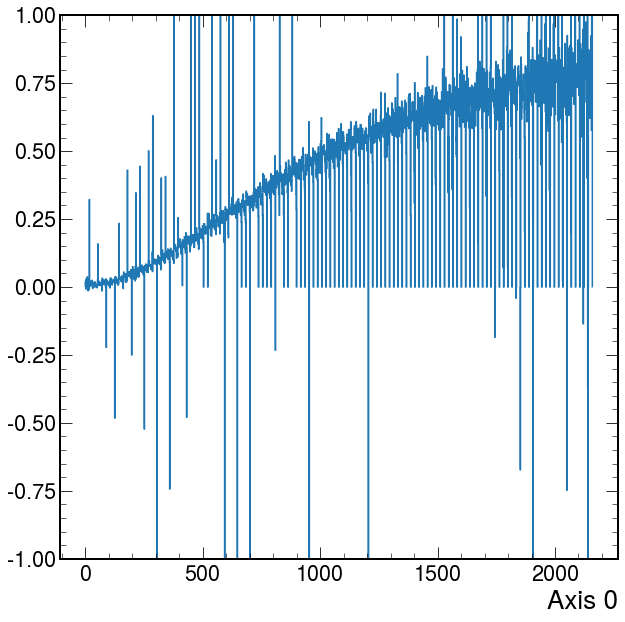

In [44]:
ha0.plot(yerr=False)
plt.ylim([-1, 1])

(-1.0, 1.0)

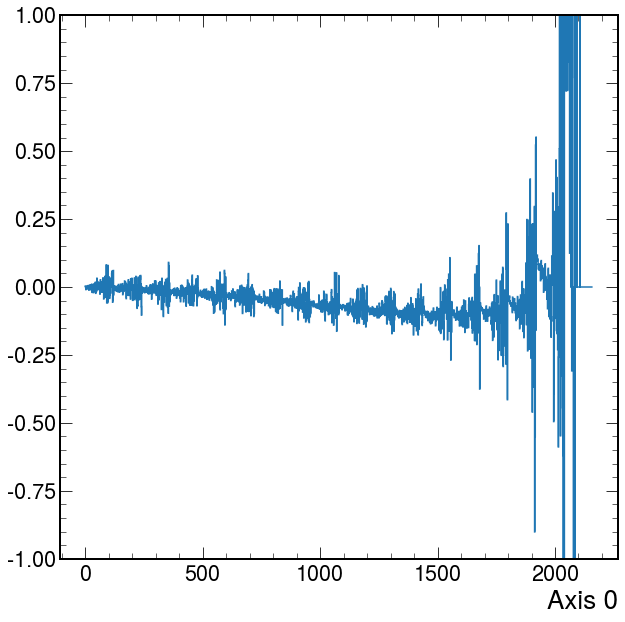

In [48]:
ha4.plot(yerr=False)
plt.ylim([-1, 1])

In [ ]:
ha0 = sel.unrolledHist(minnlohelZ_coeffs[{"helicity" : 0.j}], ("ptVgen", "absYVgen"))
ha4 = sel.unrolledHist(minnlohelZ_coeffs[{"helicity" : 4.j}], ("absYVgen", "ptVgen", ))

In [49]:
scetlibZ_A4, minnlohelZ = hh.rebinHistsToCommon([scetlibZ_A4, minnlohelZ], 1)
minnlohelZ_scaled = theory_tools.scale_angular_moments(minnlohelZ)
minnlohelZ_A4_scaled = minnlohelZ_scaled[{"helicity" : 4.j}]

NameError: name 'scetlibZ_A4' is not defined

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f3725526290>, errorbar=None, legend_artist=None)]

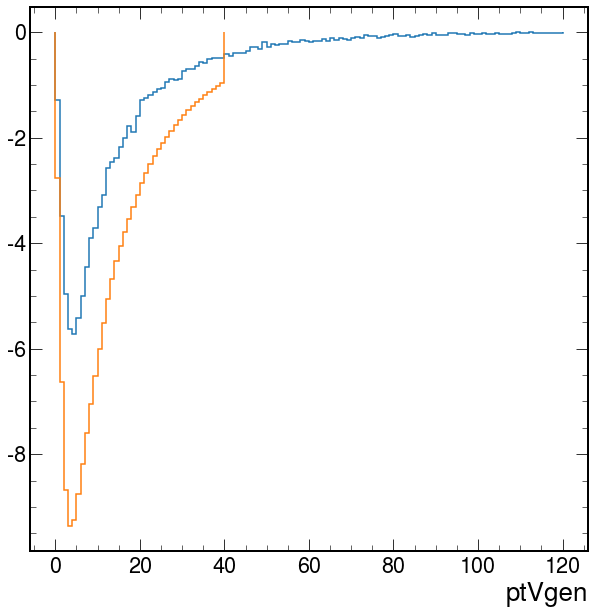

In [295]:
minnlohelZ_A4_scaled.project("ptVgen").plot(yerr=False)
scetlibZ_A4.project("pt").plot(yerr=False)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f37248b08b0>, errorbar=None, legend_artist=None)]

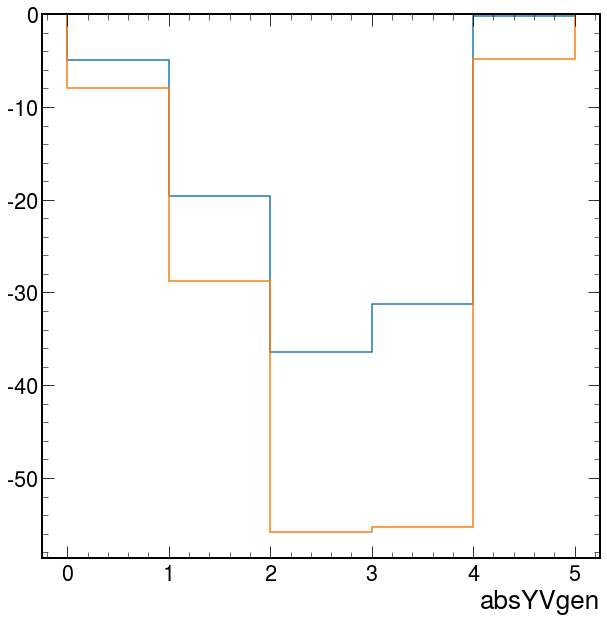

In [296]:
minnlohelZ_scaled[{"helicity" : 4.j}].project("absYVgen").plot(yerr=False)
scetlibZ_A4.project("absy").plot(yerr=False)

In [48]:
scetlibZ_a4_coeff_y = scetlib_corrections.make_a4_coeff(scetlibZ_A4.project("absy"), scetlibZ_tot.project("absy"))
minnlohelZ_coeffs_y = theory_tools.moments_to_angular_coeffs(minnlohelZ.project("absYVgen", "helicity"))

NameError: name 'scetlib_corrections' is not defined

NameError: name 'scetlibZ_A4' is not defined

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f372497f100>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

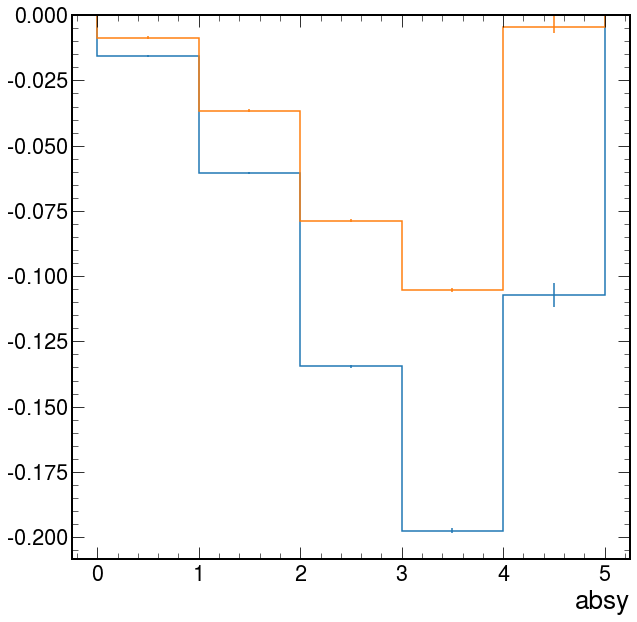

In [300]:
scetlibZ_a4_coeff_y.plot()
minnlohelZ_coeffs_y[{"helicity" : 4.j}].plot()

In [72]:
scetlibZ_a4_coeff = theory_corrections.make_a4_coeff(scetlibZ_A4.project("pt"), scetlibZ_tot.project("pt"))


NameError: name 'scetlibZ_A4' is not defined

In [45]:
scetlibZ_a4_coeff.project("pt").plot()
minnlohelZ_coeffs_pt[{"helicity" : 4.j}].plot()

NameError: name 'scetlibZ_a4_coeff' is not defined

Text(0.5, 1.0, 'Z structure functions')

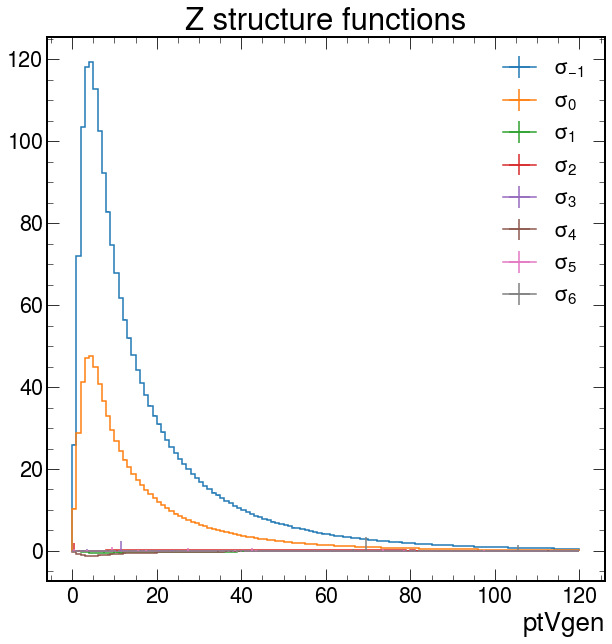

In [74]:
for i in range(8):
    minnlohelZ[{"helicity" : i}].project("ptVgen").plot(label=f"$\sigma_{{{i-1}}}$")

plt.legend()
plt.title("Z structure functions")

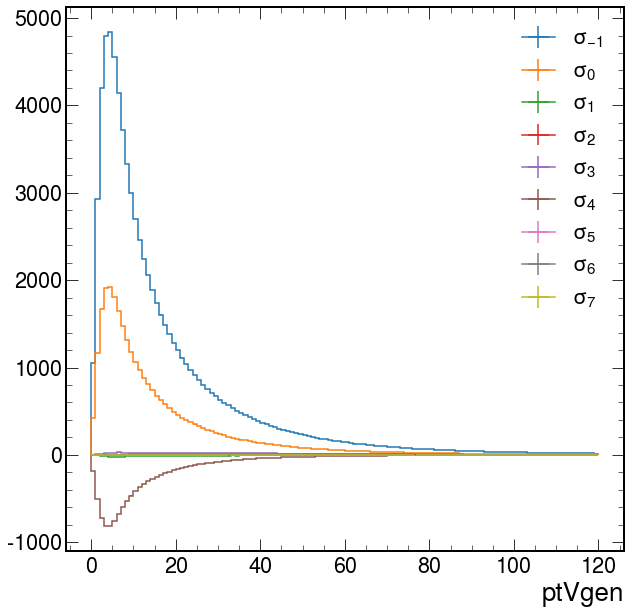

In [75]:
for i in range(-1, 8):
    minnloWmhel[{"helicity" : i+1}].project("ptVgen").plot(label=f"$\sigma_{{{i}}}$")

plt.legend()

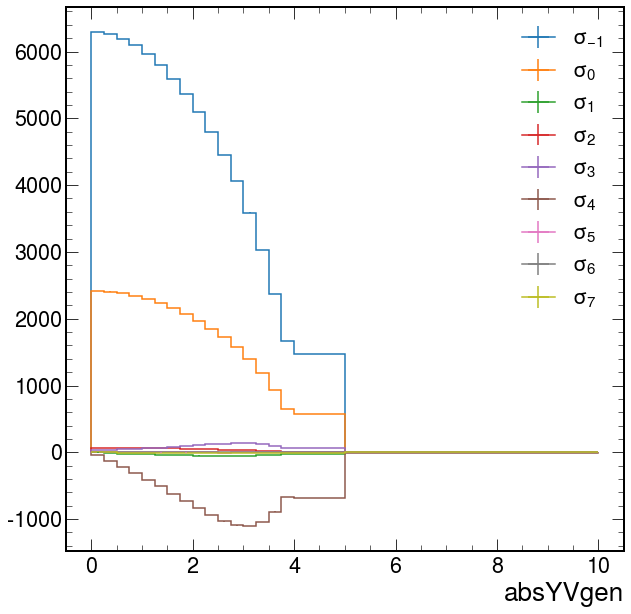

In [76]:
for i in range(-1, 8):
    minnloWmhel[{"helicity" : i+1}].project("absYVgen").plot(label=f"$\sigma_{{{i}}}$")

plt.legend()

In [81]:
fig = plot_tools.makePlotWithRatioToRef([minnloCoeffs[{"helicity" : 4.j}], scetlib_absy_A4_coeff], colors=["red", "blue"], labels=["minnlo", "scetlib"], ylabel="A$_{4}$", rrange=[0.9, 1.1], rlabel="scetlib/minnlo")

NameError: name 'minnloCoeffs' is not defined

In [ ]:
matrixRadish.plot()
minnloh.project("ptVgen").plot()

In [ ]:
f = uproot.open("/eos/user/k/kelong/HistFiles/ZGen/ZToMuMu_MATRIX_RadISH_MatchEWParams_NNPDF31.root")

In [ ]:
f["DYm50_matrix__radish/ptZ_lhe_mm"].to_hist().plot()
minnlohZ.project("ptVgen").plot()

In [ ]:
dyturbof = np.load("/eos/user/k/kelong/HistFiles/WGen/DYTurbo/wm-13tev-cms-n3ll.npz")

In [ ]:
ptax = hist.axis.Variable(dyturbof["bins"], name="pt")
dyturboh = hist.Hist(ptax, storage=hist.storage.Weight())
dyturboh[...] = np.stack((dyturbof["hist"], dyturbof["err"]), axis=-1)

In [ ]:
dyturboMatch = matrixRadish.copy()
dyturboMatch[:40] = dyturboh.view()/1000

In [ ]:
dyturboMatch

In [ ]:
scetlibMatch = matrixRadish.copy()
scetlibMatch[:40] = scetlibh_tot.project("pt").view()

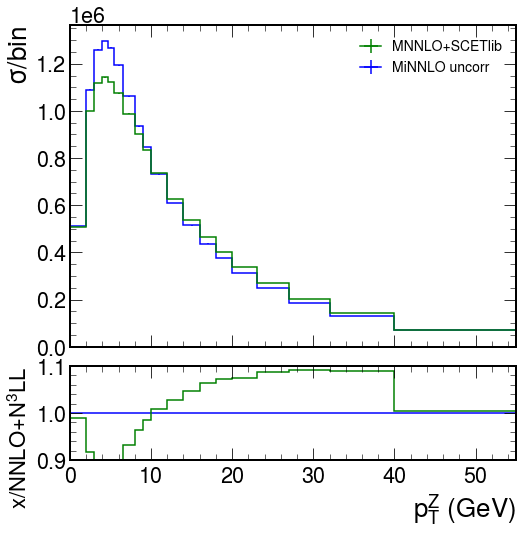

In [195]:
fig = plot_tools.makePlotWithRatioToRef([out["ZmumuPostVFP"]["output"]["dilepton_uncorr"].project("ptll"), out["ZmumuPostVFP"]["output"]["dilepton"].project("ptll"), ], colors=["blue", "green", ], labels=["MiNNLO uncorr", "MNNLO+SCETlib", ], rrange=[0.9, 1.1], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1, binwnorm=True)

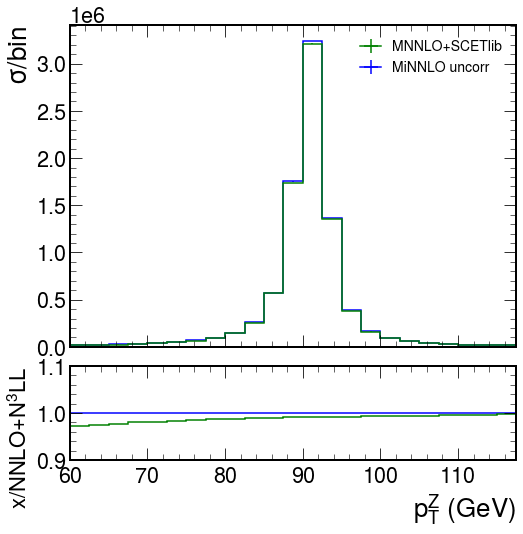

In [197]:
fig = plot_tools.makePlotWithRatioToRef([out["ZmumuPostVFP"]["output"]["dilepton_uncorr"].project("mll"), out["ZmumuPostVFP"]["output"]["dilepton"].project("mll"), ], colors=["blue", "green", ], labels=["MiNNLO uncorr", "MNNLO+SCETlib", ], rrange=[0.9, 1.1,], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1, binwnorm=True)


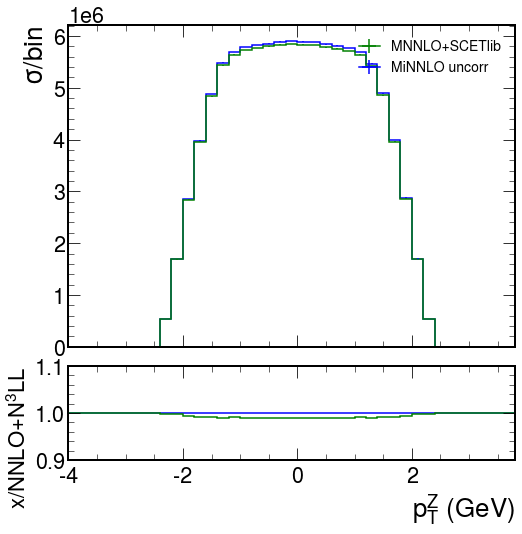

In [199]:
fig = plot_tools.makePlotWithRatioToRef([out["ZmumuPostVFP"]["output"]["dilepton_uncorr"].project("yll"), out["ZmumuPostVFP"]["output"]["dilepton"].project("yll"), ], colors=["blue", "green", ], labels=["MiNNLO uncorr", "MNNLO+SCETlib", ], rrange=[0.9, 1.1], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1, binwnorm=True)

In [169]:
from wremnants import scetlib_corrections

In [172]:
corr = scetlib_corrections.make_corr_helper(isW=False)

Shape is (1, 5, 40, 1, 1)


In [53]:
scetlibA4 = theory_corrections.read_scetlib_hist("/home/k/kelong//work/Generators/TheoryCorrections/SCETlib/Z/results/inclusive_Z_2D_yqt_A4_pdf0.npz", flip_y_sign=True)

In [54]:
scetlibA4

Hist(
  Variable([60, 120], name='mass', label='mass'),
  Variable(array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75,  5.  ]), name='y', label='y'),
  Variable(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40.]), name='pt', label='pt'),
  Integer(0, 1, underflow=False, overflow=False, name='vars', label='vars'),
  storage=Weight()) # Sum: WeightedSum(value=-87.4977, variance=0.331956)

In [23]:
scetlibWA4.project("pt")

Hist(Variable(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40.]), name='pt', label='pt'), storage=Weight()) # Sum: WeightedSum(value=-3276.25, variance=320.213)

In [25]:
scetlibWA4 = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/TheoryCorrections/SCETlib/Wminus/inclusive_Wm_A4.npz", flip_y_sign=True, nonsing="", charge=-1)


In [100]:
minnloWmhel_scaled = theory_tools.scale_angular_moments(minnloWmhel)

In [128]:
scetlibh_A4 = theory_corrections.read_scetlib_hist("/home/k/kelong/work/Generators/scetlib-cms/prod/scetlib_run/helicityTest/Wm/inclusive_Wm_A4.npz", flip_y_sign=True)
scetlibh_absy_A4 = hh.makeAbsHist(scetlibh_A4, "y")

In [129]:
scetlibh_absy_A4.shape

(1, 20, 40, 1)

In [113]:
hists = hh.rebinHistsToCommon([scetlibh_absy_A4.project("pt", "absy"), minnlohel_scaled[{"helicity" : 4.j}].project("ptVgen", "absYVgen")], 0)
hists = hh.rebinHistsToCommon(hists, 1)

In [119]:
scetlib_Wm_unrol = sel.unrolledHist(hists[0], ("absy", "pt", ))
minnlo_Wm_unrol = sel.unrolledHist(hists[1], ("absYVgen", "ptVgen", ))

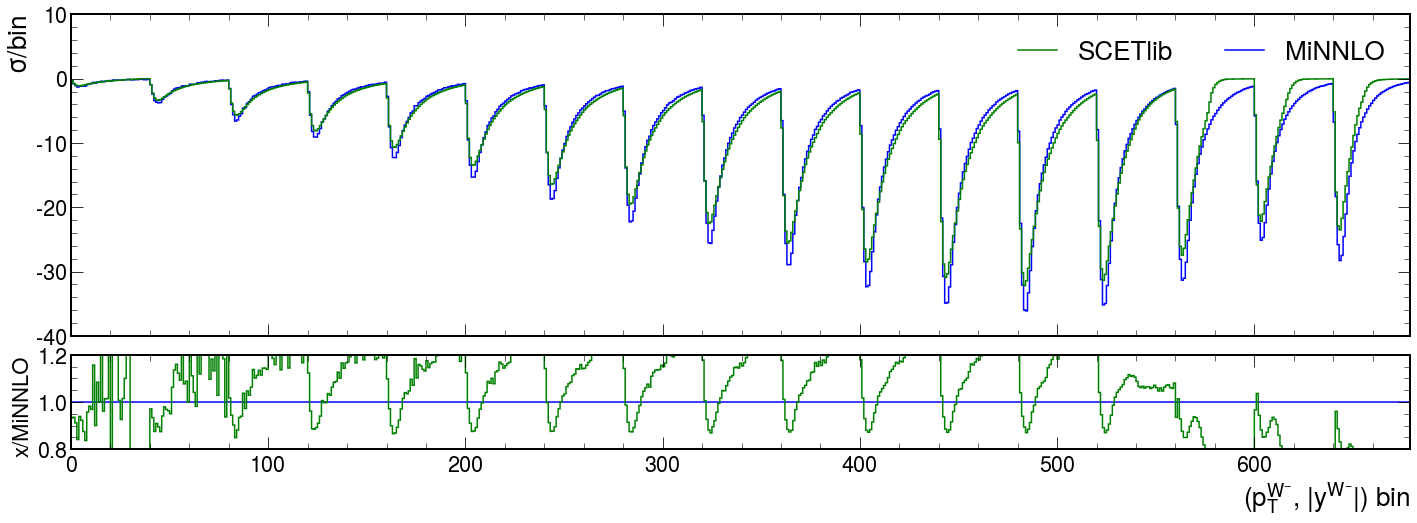

In [123]:
fig = plot_tools.makePlotWithRatioToRef([minnlo_Wm_unrol, scetlib_Wm_unrol], colors=["blue", "green", ], labels=["MiNNLO", "SCETlib", ], rrange=[0.8, 1.2], ylabel="$\sigma$/bin", xlabel="($p_{T}^{W^{-}}$, $|y^{W^{-}}|$) bin", rlabel="x/MiNNLO", nlegcols=2, binwnorm=True, ylim=[-40, 10])



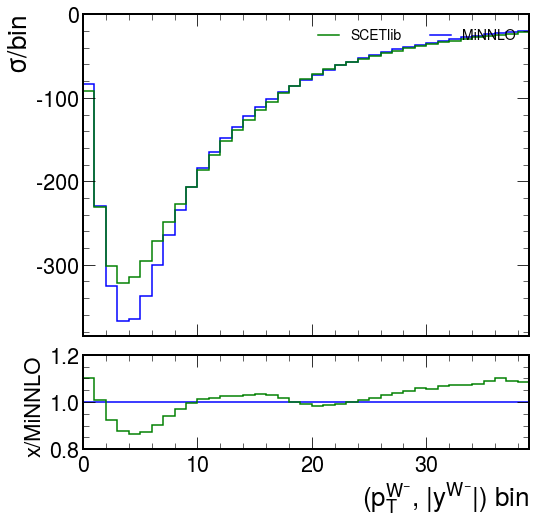

In [126]:
fig = plot_tools.makePlotWithRatioToRef([hists[1].project("ptVgen"), hists[0].project("pt")], colors=["blue", "green", ], labels=["MiNNLO", "SCETlib", ], rrange=[0.8, 1.2], ylabel="$\sigma$/bin", xlabel="($p_{T}^{W^{-}}$, $|y^{W^{-}}|$) bin", rlabel="x/MiNNLO", nlegcols=2, binwnorm=True)


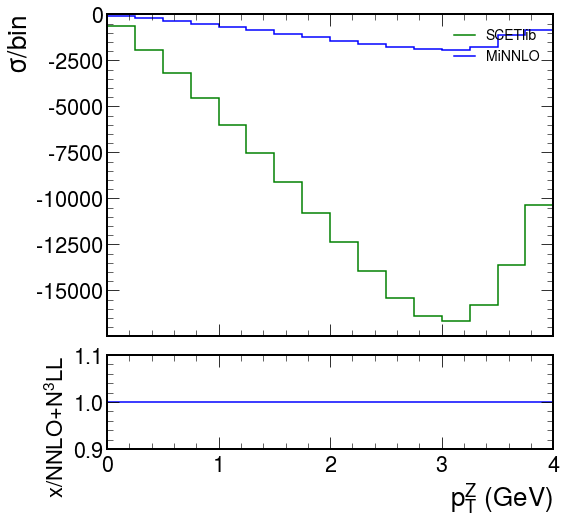

In [109]:
fig = plot_tools.makePlotWithRatioToRef([h.project(1) for h in hists], colors=["blue", "green", ], labels=["MiNNLO", "SCETlib", ], rrange=[0.9, 1.1], ylabel="$\sigma$/bin", xlabel="p$_{T}^{\mathrm{Z}}$ (GeV)", rlabel="x/NNLO+N$^{3}$LL", nlegcols=1, binwnorm=True)

